# Lab 2: Cats vs Dogs

**Deadline**: May 28, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1tiZm9V9ZVaA7D3288s4RKcLFJ7-pxJyB?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

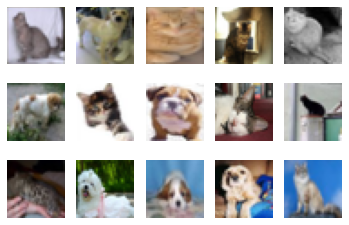

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print("The training set has ", len(train_loader), " examples")
print("The validation set has ", len(val_loader), " examples")
print("The testing set has ", len(test_loader), " examples")

The training set has  8000  examples
The validation set has  2000  examples
The testing set has  2000  examples


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

The point of setting aside the validation set is to test out and tune the hyperparameters we use for a model run using unknown data. Using the training set for this purpose would be wrong because then the result for hyperparameter testing would be overly optimistic (and therefore likely overfitting). 

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

In [ ]:
p_small = 0
p_large = 0

for param in small_net.parameters():
    p_small += param.numel()
for param in large_net.parameters():
    p_large += param.numel()

print("The number of parameters for small_net is:" + str(p_small))
print("The number of parameters for large_net is:" + str(p_large))

The number of parameters for small_net is:386
The number of parameters for large_net is:9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

64, 0.01 and 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs = 5)

Files already downloaded and verified
Files already downloaded and verified


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch 1: Train err: 0.413875, Train loss: 0.6685744047164917 |Validation err: 0.3835, Validation loss: 0.6542933229357004
Epoch 2: Train err: 0.368625, Train loss: 0.6449572525024414 |Validation err: 0.3875, Validation loss: 0.6607327796518803
Epoch 3: Train err: 0.354625, Train loss: 0.6350414371490478 |Validation err: 0.348, Validation loss: 0.6272234432399273
Epoch 4: Train err: 0.337875, Train loss: 0.6196945543289185 |Validation err: 0.3645, Validation loss: 0.6332075968384743
Epoch 5: Train err: 0.3345, Train loss: 0.6107234654426574 |Validation err: 0.3345, Validation loss: 0.6204317770898342
Finished Training
Total time elapsed: 16.54 seconds


model_small_net_bs64_lr0.01_epoch0

model_small_net_bs64_lr0.01_epoch1

model_small_net_bs64_lr0.01_epoch2

model_small_net_bs64_lr0.01_epoch3

model_small_net_bs64_lr0.01_epoch4

model_small_net_bs64_lr0.01_epoch4_train_err.csv

model_small_net_bs64_lr0.01_epoch4_train_loss.csv

model_small_net_bs64_lr0.01_epoch4_val_err.csv

model_small_net_bs64_lr0.01_epoch4_val_loss.csv

The first five are to save the model weights and biases for the current epoch (0 through 4), and the other 4 contain information on the training error, training loss, validation error and validation loss for all 5 epochs that we have gone through.

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch 1: Train err: 0.434125, Train loss: 0.6766040272712708 |Validation err: 0.387, Validation loss: 0.661381222307682
Epoch 2: Train err: 0.387625, Train loss: 0.6565615744590759 |Validation err: 0.407, Validation loss: 0.6757373213768005
Epoch 3: Train err: 0.352375, Train loss: 0.637970932006836 |Validation err: 0.3375, Validation loss: 0.627171354368329
Epoch 4: Train err: 0.33725, Train loss: 0.6174291534423828 |Validation err: 0.35, Validation loss: 0.6237144358456135
Epoch 5: Train err: 0.3305, Train loss: 0.6083939347267151 |Validation err: 0.3355, Validation loss: 0.618416078388691
Epoch 6: Train err: 0.31425, Train loss: 0.5971308832168579 |Validation err: 0.335, Validation loss: 0.617812804877758
Epoch 7: Train err: 0.314375, Train loss: 0.5922785243988037 |Validation err: 0.335, Validation loss: 0.6129911700263619
Epoch 8: Train err: 0.30775, Train loss: 0.5871761643886566 |Validation err: 0.3195, Validation loss: 0.6130947824567556
Epoch 9: Train err: 0.3045, Train loss: 

large_net (113.79s) took longer than small_net (99.03) because it has more layers and the number of layer units (and therefore more parameters to train)

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

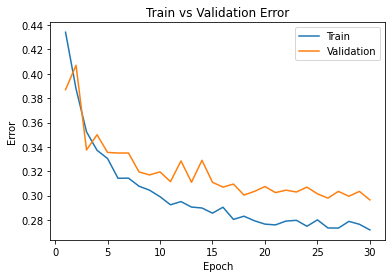

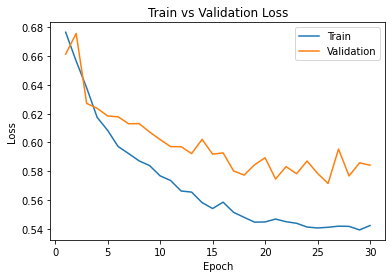

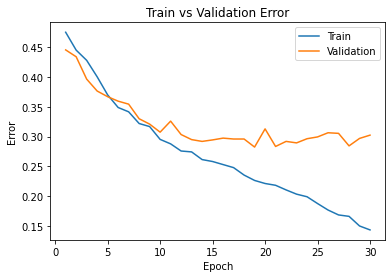

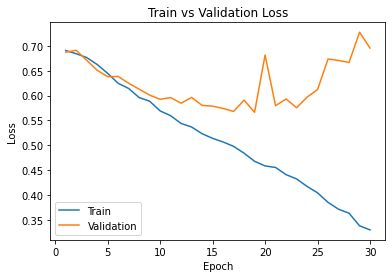

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The training curves are conitnuously decreasing for both small_net and large_net. But in general, it seems like the error and the loss are larger for large_net. For validation, the trend is the same for small_net but it plateaus for the error for large_net, and goes back up for the loss. It is clear that there is overfitting after ~20 epochs for large_net, as the loss for validation set increases with the number of epochs as the loss for training set decreases (because the model is fitting to the noise of the training set). As for underfitting, it occurs when the error/loss of both training and validation set are large. It's hard to tell if it's happening in this case, but it could be the case depending on how we set our standards for acceptable accuracy rate, as for both small_net and large_net the error and loss seem to be mostly over 30%.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

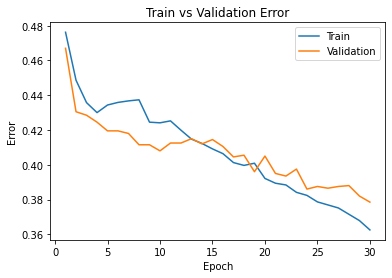

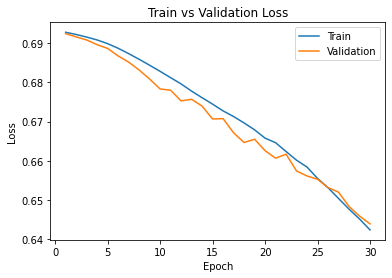

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001)
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

There seems to be no significant change to the runtime. Lowering the learning rate increased the tendency to underfit because the decrease in the error/loss wasn't as great and stayed high until the end of the run (last epoch). This is reasonable because we are taking smaller "steps" to adjust the parameters per epoch, thereby increasing the chance of not finding the minimum by the last epoch we run.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

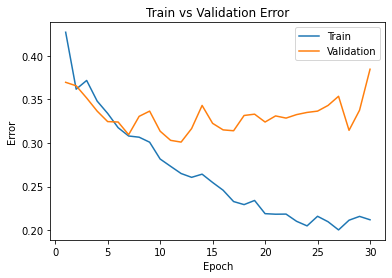

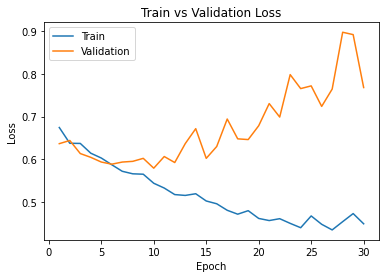

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

Similar to decreasing the learning rate, increasing it didn't have any significant impact on the runtime. However, unlike before, the model started overfitting because the steps taken per epoch was too large this time that it started to diverge from the minimum.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

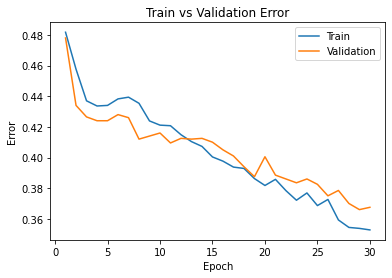

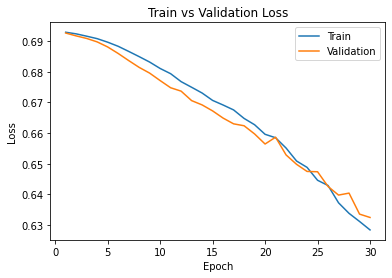

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 512)
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

The model takes shorter to run when I increased the batch size, which makes sense because the model is processing more images at the same time. It also underfits a little compared to the original run, but not significantly.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

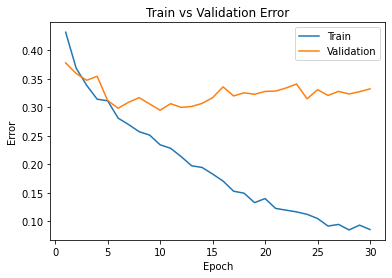

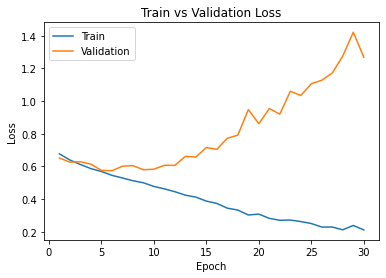

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 16)
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Decreasing the batch size increased the runtime. The validation loss increased significantly with the number of epochs, which implies that the model overfitted to the training data.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

I can try (small_net, 512, 0.001) because the validation error and loss seemed to decrease constantly with large batch size and smaller learning rate. Small net also seemed to perform better than large_net overall. The model may not converge in the number of iterations we have though, in which case we need to change the hyperparameters.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.5005, Train loss: 0.6991336420178413 |Validation err: 0.4925, Validation loss: 0.6945076286792755
Epoch 2: Train err: 0.48, Train loss: 0.6934637613594532 |Validation err: 0.4755, Validation loss: 0.6918978244066238
Epoch 3: Train err: 0.48175, Train loss: 0.6918338611721992 |Validation err: 0.465, Validation loss: 0.6914202272891998
Epoch 4: Train err: 0.472375, Train loss: 0.6913324259221554 |Validation err: 0.4645, Validation loss: 0.6911139637231827
Epoch 5: Train err: 0.469125, Train loss: 0.6907239928841591 |Validation err: 0.4565, Validation loss: 0.6905251294374466
Epoch 6: Train err: 0.466875, Train loss: 0.6903562173247337 |Validation err: 0.459, Validation loss: 0.6900540441274643
Epoch 7: Train err: 0.4635, Train loss: 0.6899680905044079 |Validation err: 0.4625, Validation loss: 0.6895745396614075
Epoch 8: Train err: 0.461, Train loss: 0.6896125487983227 |Validation err: 0.4605

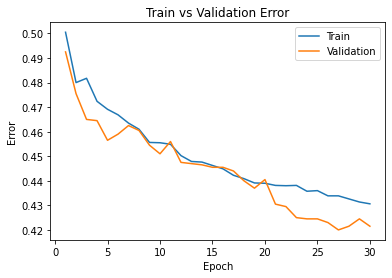

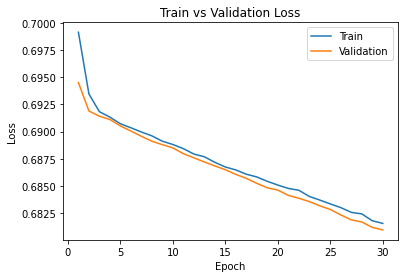

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size = 512, learning_rate = 0.001)
model_path = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

I can try (small_net, 512, 0.05) and this makes sense because large batch size would give us more confidence in the direction we're heading, and taking bigger "steps" (learning rate) towards that direction would allow us to converge better. But we've already seen that 0.1 is too high of a learning rate, so I'm choosing a value between 0.1 and 0.01.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4755, Train loss: 0.6912891007959843 |Validation err: 0.435, Validation loss: 0.6831618845462799
Epoch 2: Train err: 0.428, Train loss: 0.6782791092991829 |Validation err: 0.408, Validation loss: 0.6724957972764969
Epoch 3: Train err: 0.392, Train loss: 0.661750890314579 |Validation err: 0.3635, Validation loss: 0.6519014537334442
Epoch 4: Train err: 0.356375, Train loss: 0.6386466547846794 |Validation err: 0.3515, Validation loss: 0.635526105761528
Epoch 5: Train err: 0.339625, Train loss: 0.6229531988501549 |Validation err: 0.354, Validation loss: 0.6370099186897278
Epoch 6: Train err: 0.336375, Train loss: 0.6148376762866974 |Validation err: 0.344, Validation loss: 0.6288630217313766
Epoch 7: Train err: 0.328625, Train loss: 0.6054970994591713 |Validation err: 0.3305, Validation loss: 0.6151199787855148
Epoch 8: Train err: 0.315, Train loss: 0.5950958281755447 |Validation err: 0.3345, V

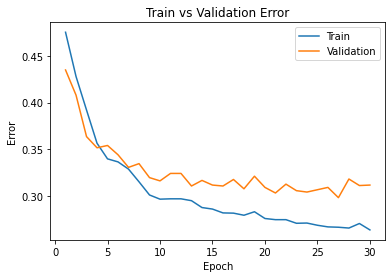

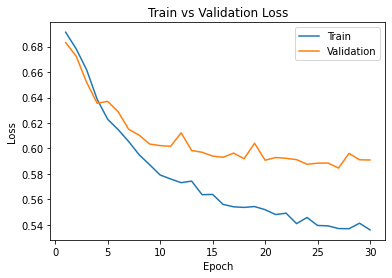

In [ ]:
small_net = SmallNet()
train_net(small_net, batch_size = 512, learning_rate = 0.05)
model_path = get_model_name("small", batch_size=512, learning_rate=0.05, epoch=29)
plot_training_curve(model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.05, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

SmallNet, batch_size and learning_rate are chosen for the same reason as above - large batch size seems to generalise better, and large learning rate helps reach the minimum within the number of epochs. The model plateaus after ~20 epochs according to the plots from 4(d), so more than 29 epochs would only result in overfitting to the training set. Also, the final training error and the final validation error are low as well compared to the other alternatives that I have tried.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
evaluate(small_net, test_loader, criterion)

Files already downloaded and verified
Files already downloaded and verified


(0.288, 0.5522167207673192)

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In this example, the test error is almost the same as validation error (slightly lower to be exact). Normally, I would expect the test error to be higher because we adjusted the hyperparameters to control the validation error even though no adjustment has been made according to the result of the test set.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

Because if test set is used anywhere else during the process, it could result in overfitting the data to the test set, resulting in the model not being able to predict new data accurately.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(3 * 32 * 32, 30)
        self.layer2 = nn.Linear(30,1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

pigeon = Pigeon()

train_net(pigeon, batch_size = 512, learning_rate = 0.005, num_epochs = 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.457125, Train loss: 0.6855881698429585 |Validation err: 0.428, Validation loss: 0.672194093465805
Epoch 2: Train err: 0.407875, Train loss: 0.6675471775233746 |Validation err: 0.4055, Validation loss: 0.6640120297670364
Epoch 3: Train err: 0.399625, Train loss: 0.6598906703293324 |Validation err: 0.3995, Validation loss: 0.6598189175128937
Epoch 4: Train err: 0.387875, Train loss: 0.6538973525166512 |Validation err: 0.4025, Validation loss: 0.6560455858707428
Epoch 5: Train err: 0.38225, Train loss: 0.6491840705275536 |Validation err: 0.396, Validation loss: 0.6539030373096466
Epoch 6: Train err: 0.379125, Train loss: 0.6460498757660389 |Validation err: 0.394, Validation loss: 0.6521193385124207
Epoch 7: Train err: 0.37125, Train loss: 0.6420500986278057 |Validation err: 0.3895, Validation loss: 0.6508487313985825
Epoch 8: Train err: 0.36725, Train loss: 0.6385269798338413 |Validation err:

In [ ]:
criterion = nn.BCEWithLogitsLoss()
evaluate(pigeon, test_loader, criterion)

(0.357, 0.6352936178445816)